In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import urllib
import json
import os, glob
from IPython.core.display import display, HTML
import logging
import pandas as pd

import warpImage
from pointAnnotator import pointAnnotator, pointCopier, points_from_path
# try:
#     import config as cfg
#     print('loaded device specific config')
# except ImportError as E:
import default_config as cfg
print('loaded default config')




display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook

logging.basicConfig(level=logging.INFO)
%load_ext autoreload


loaded default config


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Main input cell

Specify:

- `directory_list` : what parent directories to search for the session data
- `session_id` : the directory name for the experiment you want to run (eg 1231231230_366122_010120)

In [3]:
#These are the places we will look to find the probe insertion image. Make sure that the relevant directory is in this list.
directory_list = [r'\\allen\programs\mindscope\workgroups\np-exp', 
                  r'\\w10DTSM18306\neuropixels_data', 
                  r'\\w10DTSM112719\neuropixels_data']

session_id = '1202644967_623784_20220830'

In [5]:
#### get path to network folder with lims images for this mouse
mouse_num = session_id.split('_')[1]
lims_id = session_id.split('_')[0]

desired_image_filenames_contain = ['surface-image3']#2 hab 3 expe
json_string = urllib.urlopen("http://lims2/specimens/isi_experiment_details/" + mouse_num + ".json").read()
info = json.loads(json_string)

vimg_path = '\\'+os.path.normpath(info[0]['target_map_image_path'])
if not os.path.exists(vimg_path):
    logging.error('Did not get valid path for vasculature image {}'.format(vimg_path))
else:
    logging.info('Selected following vasculature image from lims: {}'.format(vimg_path))
    
%matplotlib notebook

In [33]:
#get probe insertion image
pimgFileList = []#[r"\\10.128.50.43\sd6\Habituation\958812546_484001_20191001\958812546_484001_20191001_surface-image1-left.png"]#[r"Z:\03132019_416656\2019_03_13_15_11_10_left.png"]
if len(pimgFileList) == 0:
    pimgFileList = cfg.get_insertion_image_path_from_session_id(lims_id, 
                                                                desired_image_filenames_contain=desired_image_filenames_contain,
                                                                directory_list=directory_list)  

if len(pimgFileList)==0:
    logging.error('Did not find valid probe insertion image for session {} in directories {}'.format(session_id, directory_list))

else: 
    pimg_path = pimgFileList[0]
    logging.info('Selected following probe insertion image: {}'.format(pimg_path))

    #get vasculature image
    vimg = cv2.imread(vimg_path)
    
    pimg = cv2.imread(pimg_path)
    chosen_probe_image_name = os.path.split(pimg_path)[1]
    chosen_vasculature_image_name = os.path.split(vimg_path)[1]

    #change from opencv bgr default back to rgb
    pimg = pimg[:, :, [2,1,0]]
    vimg = vimg[:, :, [2,1,0]]
    aspect = (pimg.shape[0]+vimg.shape[0])/float(np.max([pimg.shape[1], vimg.shape[1]]))
    
    save_directory = os.path.dirname(pimg_path)

INFO:root:Selected following probe insertion image: \\allen\programs\mindscope\workgroups\np-exp\1202644967_623784_20220830\1202644967_623784_20220830_surface-image3-left.png


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Annotate all inserted probes in original insertion image

Mark where each probe entered the brain as closely as you can. Skip probes that weren't inserted. Annotate in alphabetical order.

<IPython.core.display.Javascript object>


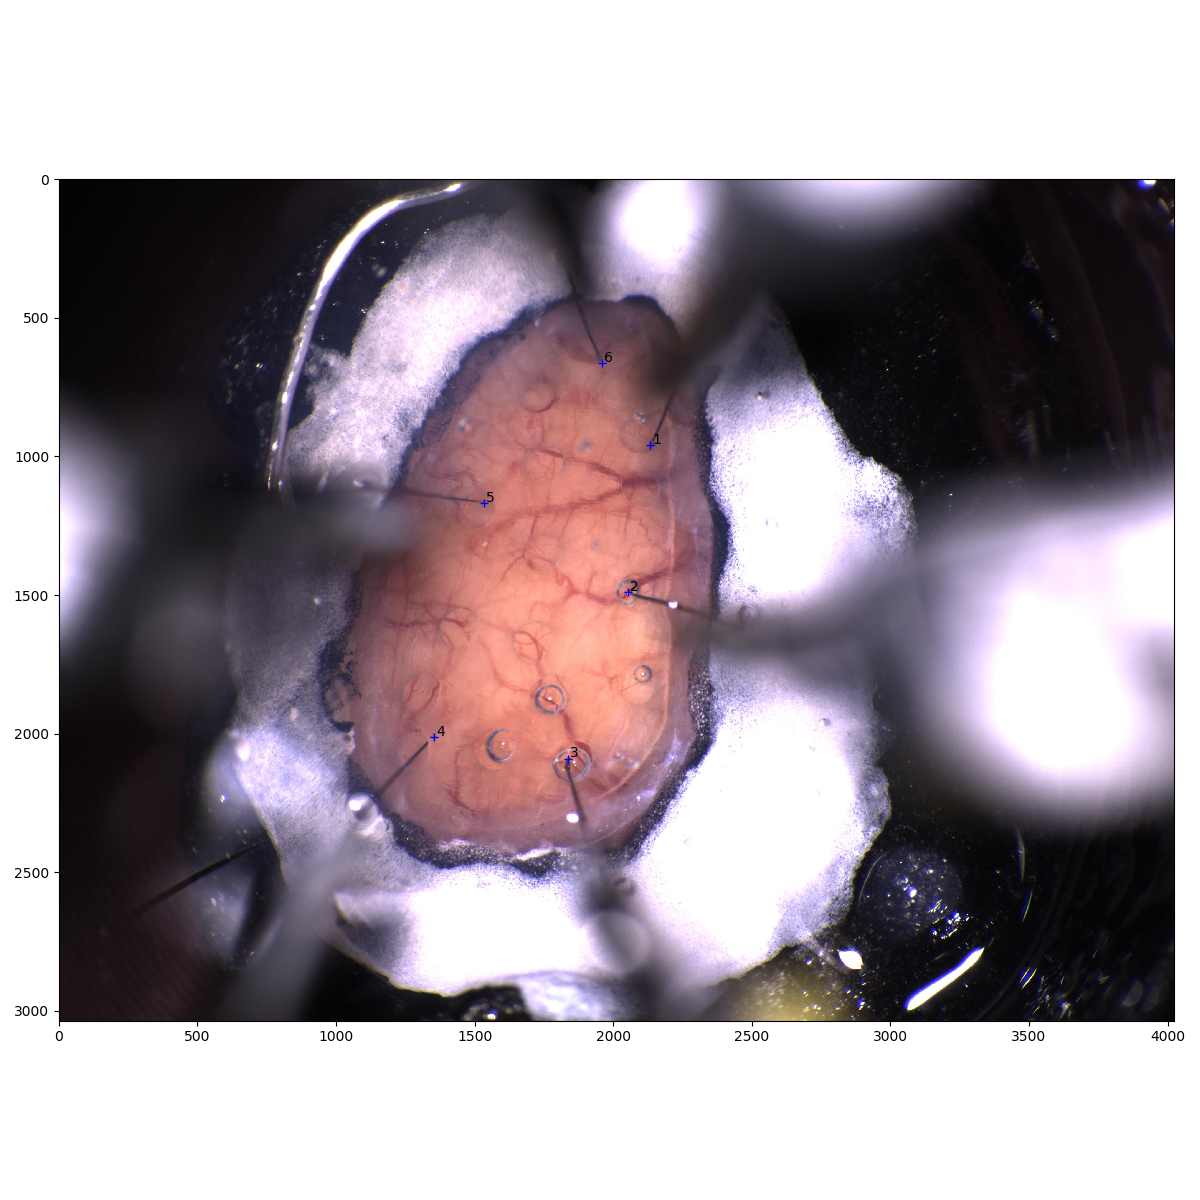

In [25]:
fig, ax = plt.subplots(figsize=(12,12))

pim = ax.imshow(pimg, origin='upper')
ppa = pointAnnotator(pim, ax)
plt.tight_layout(pad=1, w_pad=0, h_pad=0)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Indicate which probes were inserted

You will be prompted to list the inserted probes when you execute the next cell. Separate probe letters with commas.

In [30]:
probes_inserted = raw_input()

F, E, D, C, B, A


In [57]:
probes_inserted_parsed = np.sort(probes_inserted.upper().replace(' ', '').split(','))
print(probes_inserted_parsed)

if len(probes_inserted_parsed) != len(ppa.points):
    logging.error('Number of probes inserted {} does not match number of annotations {}'.format(len(probes_inserted_parsed), len(ppa.points)))

['A' 'B' 'C' 'D' 'E' 'F']


In [49]:
#Save these annotations
save_dict = {}
for probe, anno in zip(probes_inserted_parsed, ppa.points):
    save_dict[probe] = anno

save_dict['coords'] = ['x', 'y']
df = pd.DataFrame(save_dict)
df = df.set_index('coords')
df.to_csv(os.path.join(save_directory, 'probelocator_' + session_id + '_insertions_in_rig_image_space.csv'))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Select Bounding Box for zoom

Annotate four points on the right image that indicate where to crop the image to match the field of view on the left. The order of the points don't matter. Just place them at the corners of the bounding box. This doesn't have to be super precise.

<IPython.core.display.Javascript object>


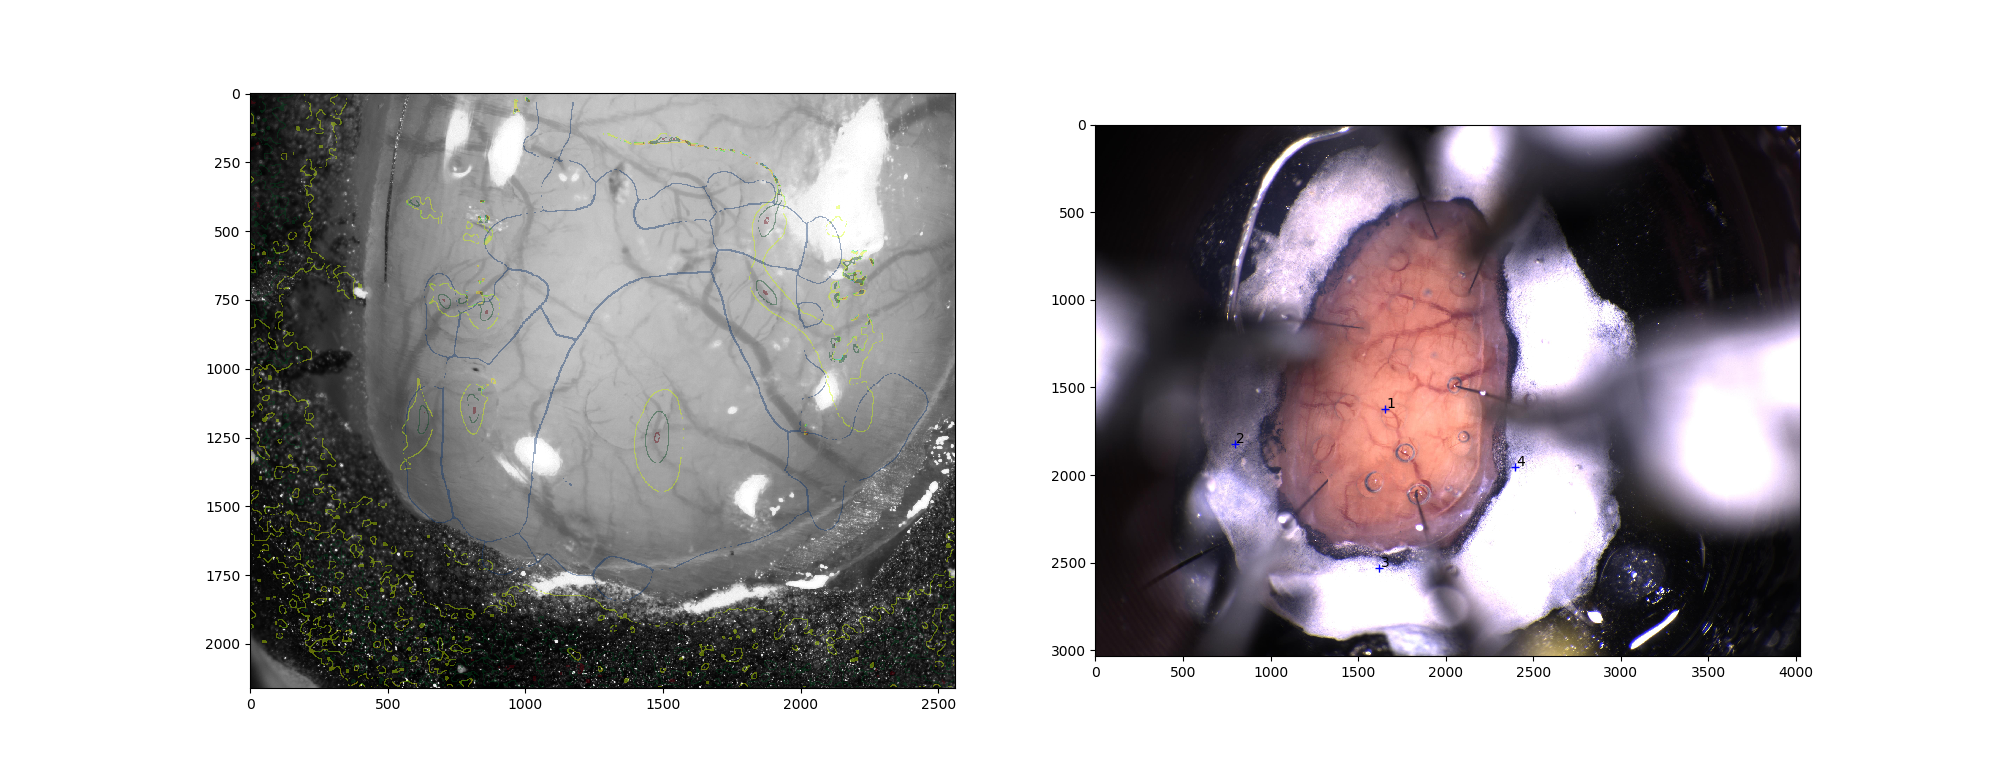

found npz 1202644967_623784_20220830.ISIregistration.npz


In [8]:
zoom_fig, zoom_ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
vax = zoom_ax[0]
pax = zoom_ax[1]

vim = vax.imshow(vimg, origin='upper')
pim = pax.imshow(pimg, origin='upper')
zoom_ppa = pointAnnotator(pim, pax)
zoom_bounding_box = points_from_path(pimg_path, chosen_vasculature_image_name, 'landmark')


In [48]:
zoom_ppa.points
left_bound = int(np.min([point[1] for point in zoom_ppa.points]))
right_bound = int(np.max([point[1] for point in zoom_ppa.points]))

lower_bound = int(np.min([point[0] for point in zoom_ppa.points]))
upper_bound = int(np.max([point[0] for point in zoom_ppa.points]))

cropped_pimage = pimg[left_bound:right_bound, lower_bound:upper_bound]

np.save(os.path.join(save_directory, 'probelocator_' + session_id + '_insertion_image_bounding_box.npy'),
       [left_bound, right_bound, lower_bound, upper_bound])

<IPython.core.display.Javascript object>


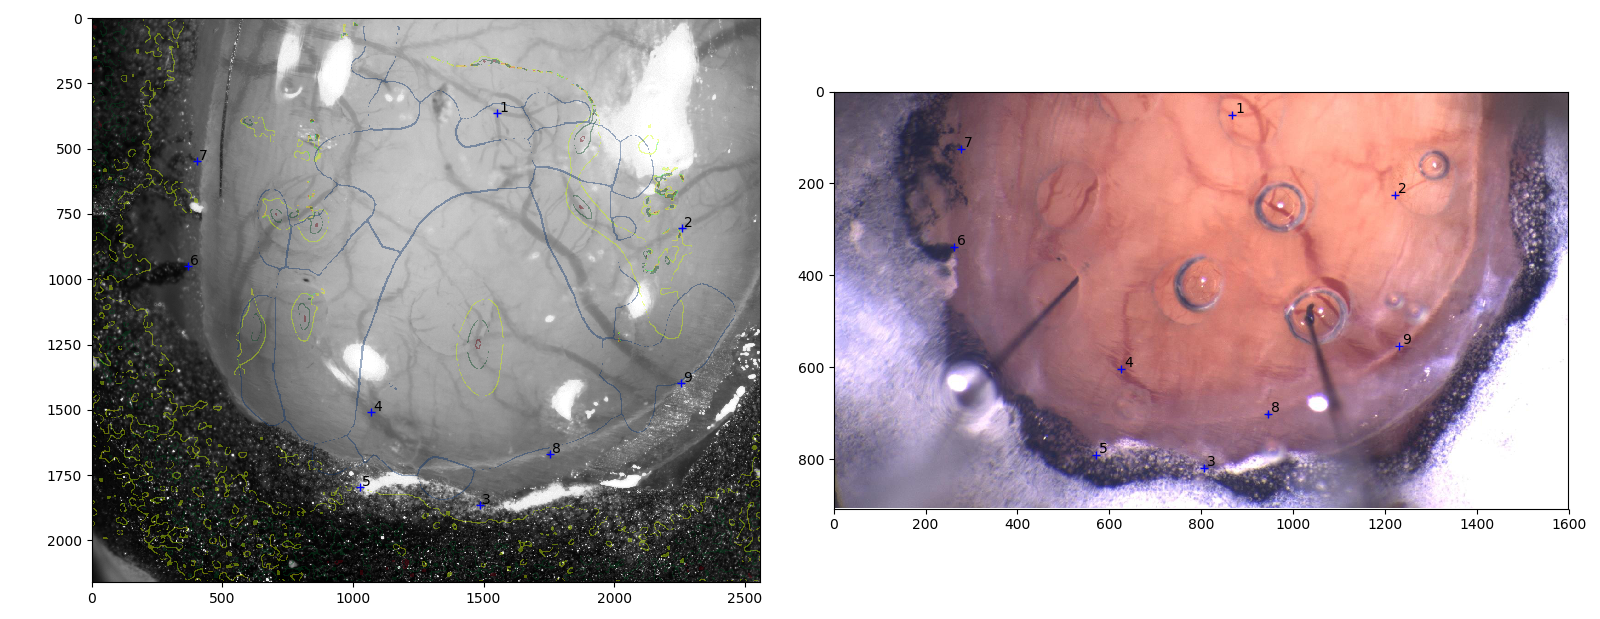

found npz 1202644967_623784_20220830.ISIregistration.npz
found npz 1202644967_623784_20220830.ISIregistration.npz


In [10]:
fiducial_fig, fiducial_ax = plt.subplots(1,2, figsize=(16,16/(2*aspect)))
vax = fiducial_ax[0]
pax = fiducial_ax[1]

fiducial_image = vimg
    
vim = vax.imshow(fiducial_image, origin='upper')
vpa = pointAnnotator(vim, vax)
vasculature_landmark_points = points_from_path(pimg_path, chosen_vasculature_image_name, 'landmark')

#Comment out the following line if you don't want it to load previous points
#vpa.loadPoints(vasculature_landmark_points)

pim = pax.imshow(cropped_pimage, origin='upper')
ppa = pointAnnotator(pim, pax)
probe_landmark_points = points_from_path(pimg_path, chosen_probe_image_name, 'landmark')

#Comment out the following line if you don't want it to load previous points
#ppa.loadPoints(probe_landmark_points)

plt.tight_layout(pad=1, w_pad=0, h_pad=0)

<IPython.core.display.Javascript object>


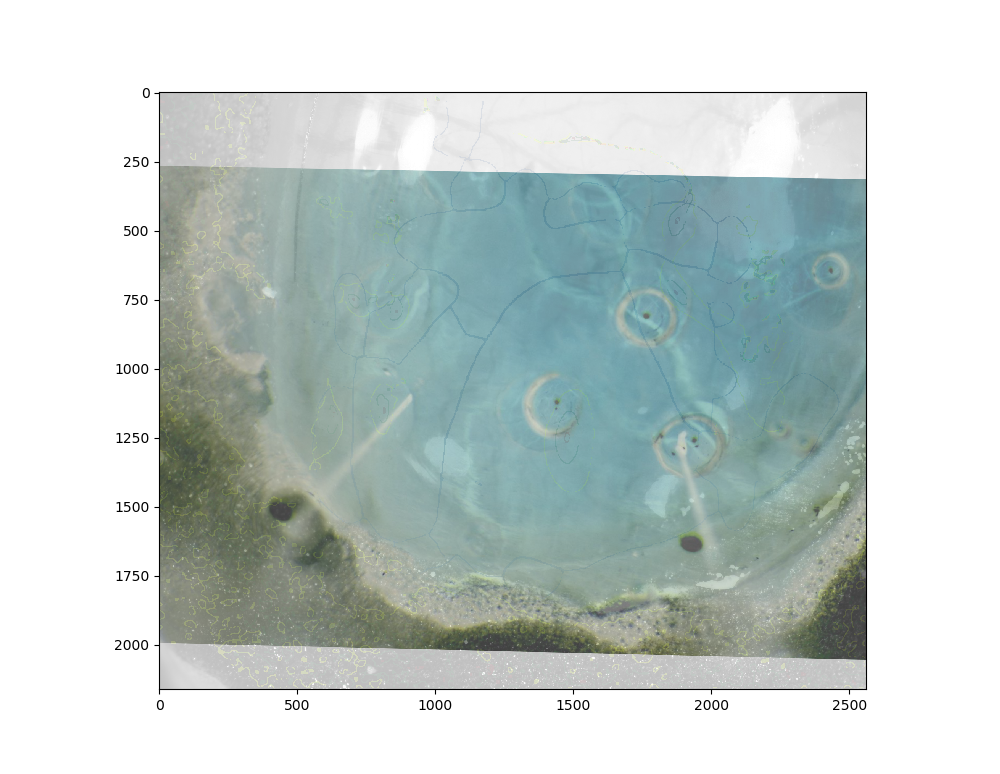

In [11]:
#Compute perspective transform to warp probe insertion image to vasculature image coordinates

#reshape points into [numpoints, 2] arrays
ppoints = ppa.points #np.stack((ppa.xs, ppa.ys)).astype(np.float32).T
vpoints = vpa.points #np.stack((vpa.xs, vpa.ys)).astype(np.float32).T

#get perspective transform between images and apply it to probe insertion image
perspective = cv2.findHomography(ppoints, vpoints)
pimg_transform = cv2.warpPerspective(cropped_pimage, perspective[0], (vimg.shape[1], vimg.shape[0]))

#transform probe insertion points to use in local warping or plot on transformed image
ppoints_transform = cv2.perspectiveTransform(np.array([ppoints.astype(np.float32)]), perspective[0])
ppoints_transform = np.squeeze(ppoints_transform)

#plot overlay of vasculature image and transformed image to compare
overlay_fig, overlay_ax = plt.subplots(figsize=(10,10/aspect))
overlay_ax.imshow(vimg, alpha=0.5)
overlay_ax.imshow(255-pimg_transform, alpha=0.5)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Annotate probe insertions in the warped image

Annotate any probes in the warped image. Annotate them in alphabetical order and skip any probes that weren't inserted or don't appear in this window.

<IPython.core.display.Javascript object>


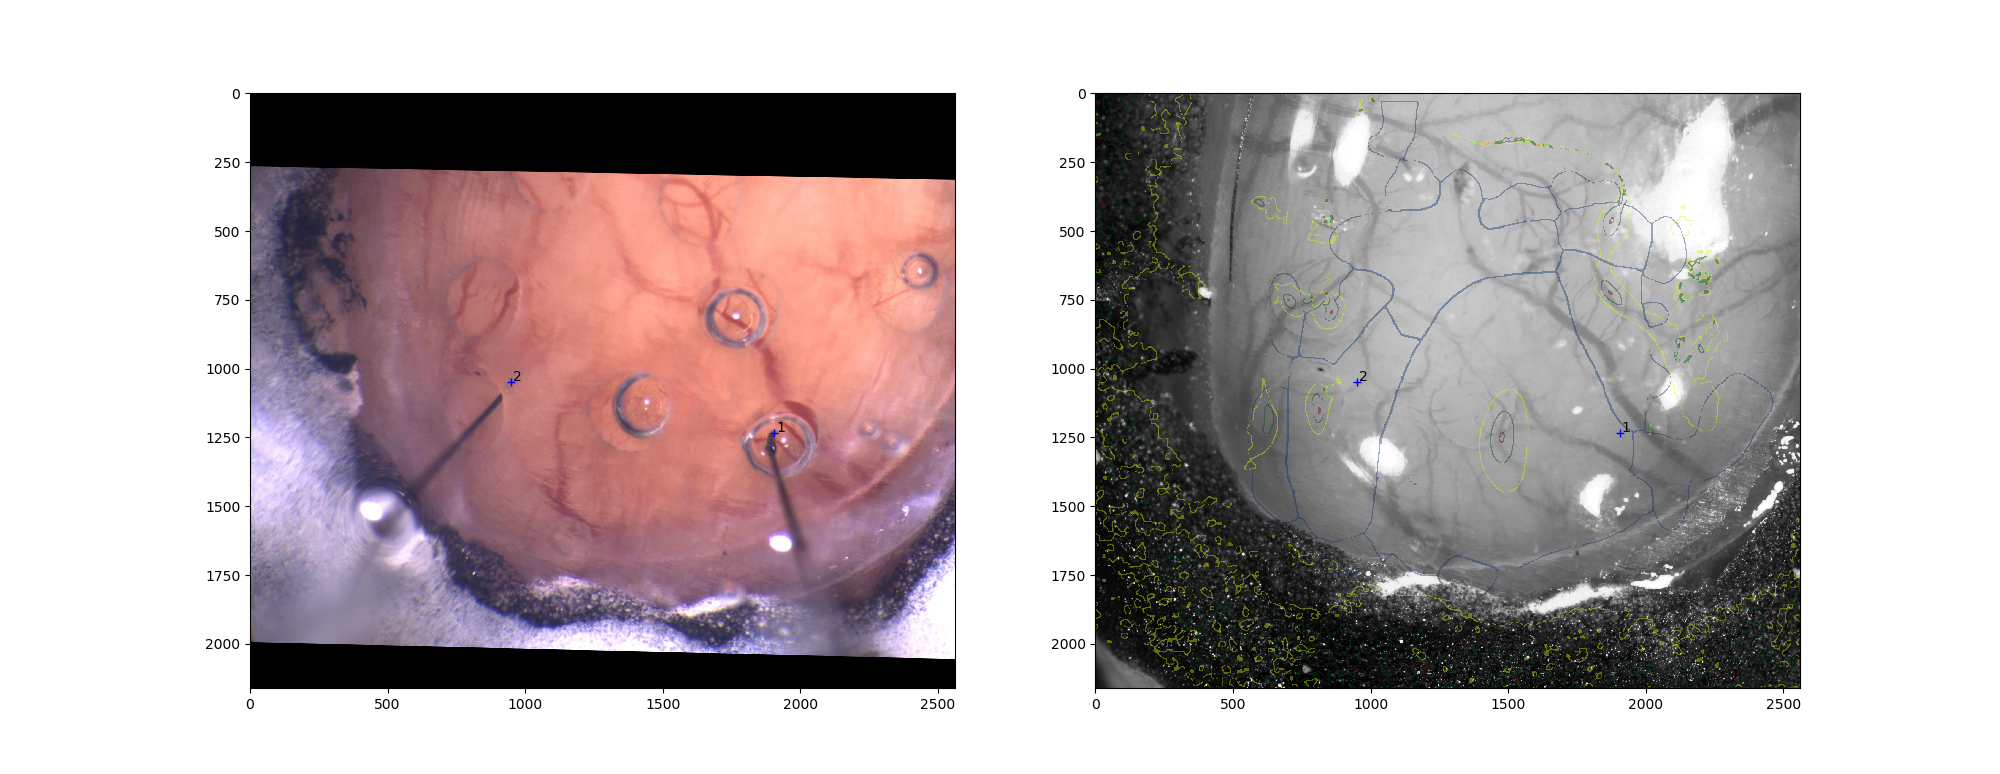

found npz 1202644967_623784_20220830.ISIregistration.npz


In [12]:
#Select location of probe insertion points in this warped image
insertion_location_fig, insertion_location_ax = plt.subplots(1,2, figsize=(20,20/(2*aspect)))
paffax = insertion_location_ax[0]

vax2 = insertion_location_ax[1]

paff_im = paffax.imshow(pimg_transform, origin='upper')
paffp = pointAnnotator(paff_im, paffax)
probe_insertion_points = points_from_path(pimg_path, chosen_vasculature_image_name, chosen_probe_image_name, 'insertion')
paffp.loadPoints(probe_insertion_points)

#paffpoints = paffp.points  # np.stack((paffp.xs, paffp.ys)).astype(np.float32).T


vim2 = vax2.imshow(vimg, origin='upper')
vpa = pointCopier(vim2, vax2, paffax)
vpa.loadPoints(probe_insertion_points)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Input info about the probes you annotated in the cell above including, which probes they were, where they were inserted and how confident you were in you annotation

You will be prompted to list this info in the following three cells. Keep the order in which you enter the info consistent (ie, if you list 'C' first, enter where 'C' was inserted first in the next input cell etc).

**Enter which probes were annotated in the warped image above**:  Separate entries with commas

In [74]:
probes_in_viscortex = raw_input()

'c',  'D'


**Enter which brain area the probes entered (in same order as cell above)**

Separate entries with commas. Your options are: VISp (V1), VISam (AM), VISpm (PM), VISl (LM), VISal (AL), VISrl (RL), VISrll (RLL), VISli (LI), VISlla (LLA), VISmma (MMA), VISmmp (MMP), nonVis. The names in parentheses are just given as a key to the image below but shouldn't be used. Here's a map of these areas:



<div>
<img src="mouse_visual_areas.PNG", width="300"/>
</div>

In [82]:
area_list = raw_input()

'VISp' ,'visL'


**Indicate your confidence in this annotation**:  From 1 (not confident) to 5 (very confident). Separate with commas.

In [91]:
confidence = raw_input()

5,5


In [92]:
clean_up_string = lambda s: s.replace('"', '').replace("'", '').replace(' ', '')
probes_in_viscortex_parsed = clean_up_string(probes_in_viscortex).upper().split(',')
area_list_parsed = clean_up_string(area_list).lower().replace('vis', 'VIS').split(',')
confidence_parsed = clean_up_string(confidence).split(',')

for name, data in zip(['Probes', 'Areas', 'Confidence'],
                [probes_in_viscortex_parsed, area_list_parsed, confidence_parsed]):
    print(name, data)
    if len(data) != len(paffp.points):
        logging.error('Number of entries in {}({}) does not match number of annotations ({}). Please go back and correct this.'.format(name, len(data), len(paffp.points)))

('Probes', ['C', 'D'])
('Areas', ['VISp', 'VISl'])
('Confidence', ['5', '5'])


In [59]:
#Save these annotations
save_dict = {}
for probe, anno in zip(probes_in_viscortex_parsed, paffp.points):
    save_dict[probe] = anno

save_dict['coords'] = ['x', 'y']
df = pd.DataFrame(save_dict)
df = df.set_index('coords')
df.to_csv(os.path.join(save_directory, 'probelocator_' + session_id + '_insertions_in_vasculature_image_space.csv'))

In [94]:
from imp import reload
reload(cfg)
print(pimg_path)

# save points and transformation matrix
save_path = cfg.get_save_path(pimg_path)
save_dir = os.path.split(save_path)[0]

if not(os.path.isdir(save_dir, )):
    os.mkdir(save_dir)
    
save_dict = {}
save_dict['vasculatureImageKeypoints'] = vpoints
save_dict['probeImageKeypoints'] = ppoints
save_dict['vasculatureToProbeInsertionTransform'] = perspective[0]
save_dict['probeInsertionPointsTransformed'] = paffp.points
save_dict['probe_image_bounding_box'] = zoom_ppa.points

if not('contributingInsertionImageNames' in save_dict):
    save_dict['contributingInsertionImageNames']=[{}]
contributingInsertionImageNames_dict = save_dict['contributingInsertionImageNames'][0]
    
this_image_pair = (chosen_probe_image_name, chosen_vasculature_image_name)
probe_list = ['A', 'B', 'C', 'D', 'E', 'F']
# probe_list = [p for area,p in zip(area_list, probe_list) if area != '']
# area_list = [area for area in area_list if area != '']
for probe in probe_list:
    if not(probe in contributingInsertionImageNames_dict):
        contributingInsertionImageNames_dict[probe] = []
    contributingInsertionImageNames_dict[probe].append(this_image_pair)

save_dict['contributingInsertionImageNames'][0] = contributingInsertionImageNames_dict

if not('probesFromImagePair' in save_dict):
    save_dict['probesFromImagePair']=[{}]
probesFromImagePair_dict = save_dict['probesFromImagePair'][0]
probesFromImagePair_dict[this_image_pair] = probe_list
save_dict['probesFromImagePair'][0] = probesFromImagePair_dict


if not('imagePairCoordinates' in save_dict):
    save_dict['imagePairCoordinates']=[{}]
imagePairCoordinates_dict = save_dict['imagePairCoordinates'][0]


imagePairCoordinates_dict[chosen_vasculature_image_name+'_landmark_points'] = vpoints
imagePairCoordinates_dict[chosen_probe_image_name+'_landmark_points'] = ppoints
imagePairCoordinates_dict[chosen_probe_image_name+'_to_'+chosen_vasculature_image_name+'_transform'] = perspective[0]
imagePairCoordinates_dict[chosen_probe_image_name+'_to_'+chosen_vasculature_image_name+'_insertion_points'] = paffp.points

save_dict['imagePairCoordinates'][0] = imagePairCoordinates_dict


session_name = cfg.get_session_name(pimg_path)

np.savez(save_path, **save_dict)

save_images_dict = {
    'insertionLocation':insertion_location_fig,
    'overlay':overlay_fig, 
    'fiducial':fiducial_fig
}
for name, fig in save_images_dict.items():
    image_path = os.path.join(save_dir, session_name+'.'+name+'.png')
    print(image_path)
    fig.savefig(image_path)

### SAVE TRANSFORMED PROBE IMAGE TO USE FOR DAY 2 ALIGNMENT IF NECESSARY
camera_used_for_probe_image = 'left' if 'left' in os.path.basename(pimg_path) else 'right'
warped_save_path = os.path.join(save_dir, session_name+'_'+camera_used_for_probe_image+'.warpedInsertionImage.png')
print(warped_save_path)
cv2.imwrite(warped_save_path, pimg_transform)

column_list = [
    'Probe',
    'Area',
    'Confidence score',
    'Estimate microns error',
    'Notes',
    'Estimate microns error X',
    'Estimate microns error Y',
    'ISI Pixel Coordinate X',
    'ISI Pixel Coordinate Y',
    'Images Used'
]


csv_path = os.path.join(save_dir, session_name+'.areaClassifications.csv')
try:
    current_csv_df = pd.read_csv(csv_path,  index_col=False)
except IOError as E:
    current_csv_df = pd.DataFrame(columns=column_list)


current_csv_df.loc[:, 'Probe'] = probes_in_viscortex_parsed
current_csv_df.loc[:, 'Area'] = area_list_parsed
current_csv_df.loc[:, 'Confidence score'] = confidence_parsed
current_csv_df.loc[:, 'ISI Pixel Coordinate X'] = paffp.points[:, 0]
current_csv_df.loc[:, 'ISI Pixel Coordinate Y'] = paffp.points[:, 1]
current_csv_df.loc[:, 'Images Used'] = [str(this_image_pair)]*(len(probes_in_viscortex_parsed))

current_csv_df.to_csv(csv_path, index=False)



\\allen\programs\mindscope\workgroups\np-exp\1202644967_623784_20220830\1202644967_623784_20220830_surface-image3-left.png
\\allen\programs\mindscope\workgroups\np-exp\1202644967_623784_20220830\1202644967_623784_20220830.insertionLocation.png
\\allen\programs\mindscope\workgroups\np-exp\1202644967_623784_20220830\1202644967_623784_20220830.fiducial.png
\\allen\programs\mindscope\workgroups\np-exp\1202644967_623784_20220830\1202644967_623784_20220830.overlay.png
\\allen\programs\mindscope\workgroups\np-exp\1202644967_623784_20220830\1202644967_623784_20220830_left.warpedInsertionImage.png


In [97]:
current_csv_df.head(6)

Probe  Area Confidence score Estimate microns error Notes  \
0     C  VISp                5                    NaN   NaN   
1     D  VISl                5                    NaN   NaN   

  Estimate microns error X Estimate microns error Y  ISI Pixel Coordinate X  \
0                      NaN                      NaN             1905.432739   
1                      NaN                      NaN              949.809570   

   ISI Pixel Coordinate Y                                        Images Used  
0             1233.730835  ('1202644967_623784_20220830_surface-image3-le...  
1             1048.419800  ('1202644967_623784_20220830_surface-image3-le...

# Manually save the notebook (Press ctrl S)

In [25]:
# save notebook as html
saveDirectory = os.path.dirname(pimg_path)
os.system('jupyter nbconvert probeInsertionLocator.ipynb --output ' + os.path.join(saveDirectory, 'probeInsertionNotebook.html'))

0